# Demo 4 (the finale!): ATRP reaction in polymerist demo
In this final notebook, we put everything I've taught you in these examples together to show what a self-contained 'polymerist' workflow might look like  
This example shows how to go from **NOTHING** (besides this notebook, of course) to a completed polymer simulation; *this is the real power of polymerist*

This example specifically focuses on zwitterionic methacrylate polymers formed from atom-transfer radical polymerization,  
though the approaches outlined are adaptable for almost any linear polymer systems with little tweaking

## Set logging and display settings

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)


from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, disable_kekulized_drawing

MOL_IMG_WIDTH  : int = 400
MOL_IMG_HEIGHT : int = 300
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

disable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


## Define output directories

In [2]:
from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path


OUTPUT_DIR = Path('scratch_MD') # dummy directory for writing without tampering with example inputs
OUTPUT_DIR.mkdir(exist_ok=True)

WORKING_DIR = OUTPUT_DIR / 'ATRP_demo'
WORKING_DIR.mkdir(exist_ok=True)

project_name : str = 'ATRP_polymer_brush'

# Defining polymerization reaction

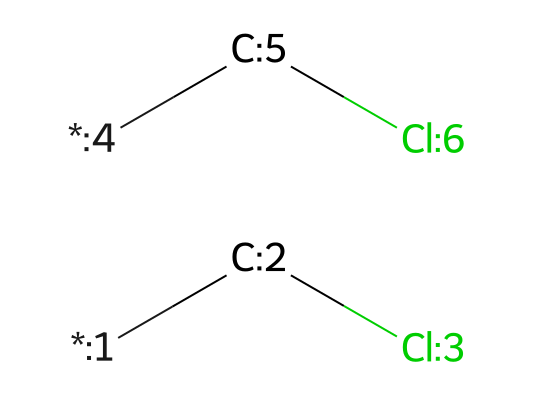

In [3]:
from rdkit import Chem
from polymerist.rdutils.reactions.assembly import ReactionAssembler


alkyl_chloride = Chem.MolFromSmarts('*-C-Cl')  # this is the moiety active in the ATRP reaction
assembler = ReactionAssembler(
    reactive_groups=[  # reaction takes place between two alkyl chlorides
        Chem.Mol(alkyl_chloride),
        Chem.Mol(alkyl_chloride),
    ],
    byproducts=[Chem.MolFromSmarts('[Cl]-[Cl]')], # eject Cl2 byproduct
    rxn_name='atom-transfer radical polymerization',
)
display(assembler.reactants)

INFO:polymerist.rdutils.bonding.permutation:3 --x-> 2


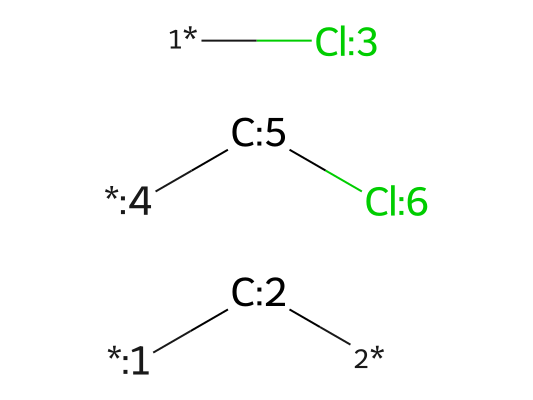

INFO:polymerist.rdutils.bonding.permutation:5 --x-> 6


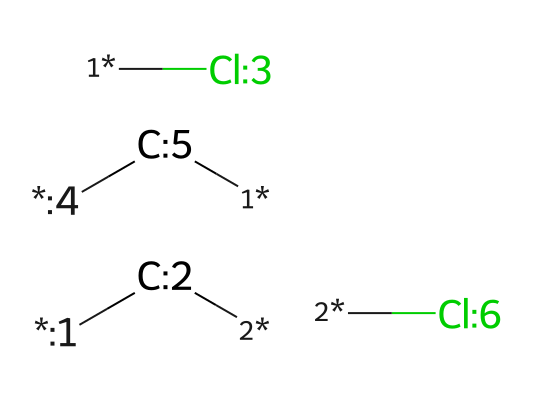

INFO:polymerist.rdutils.bonding.permutation:3 ----> 6


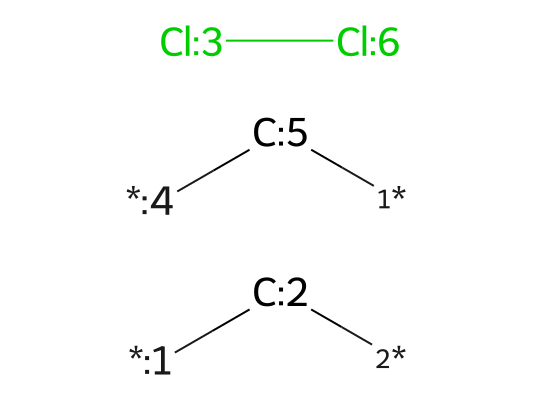

INFO:polymerist.rdutils.bonding.permutation:5 ----> 2


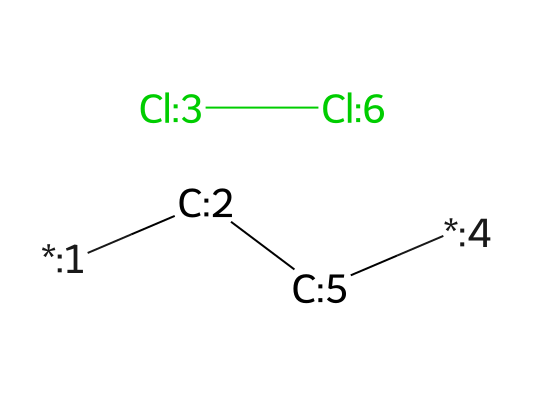

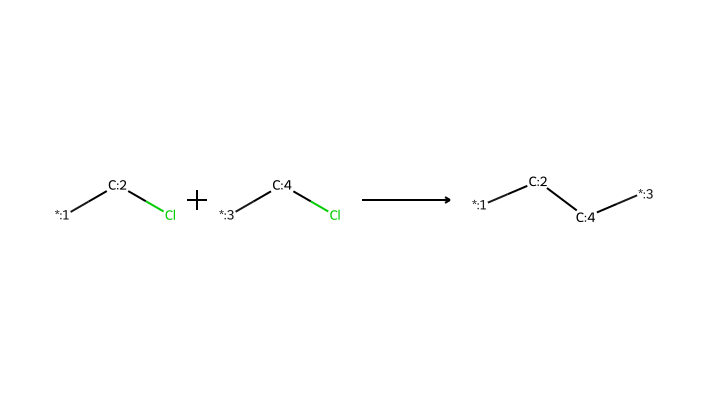

In [4]:
assembler.bond_derangement = {
    3 : (2, 6), # keys are the indices of pivot atoms; values are the atom indices to which the pivot was and will be bonded, respectively
    5 : (6, 2),    
}
rxn = assembler.assemble_rxn(show_steps=True)
display(rxn)

In [5]:
rxn.to_rxnfile(WORKING_DIR / 'atrp.rxn')
rxn_smarts = rxn.to_smarts()

# Enumerating all possible repeat unit fragments

## Define monomers

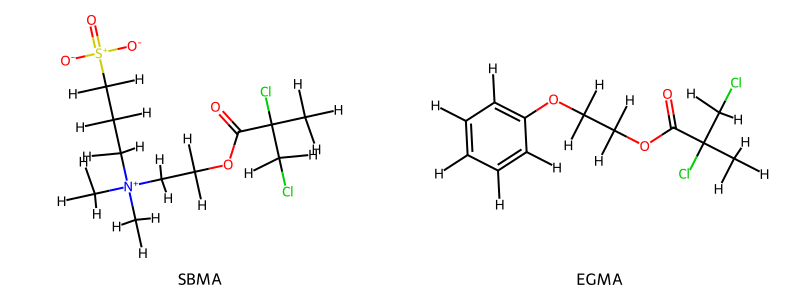

In [6]:
from polymerist.rdutils.sanitization import explicit_mol_from_SMILES, Smiles

monomer_smiles : dict[str, str] = {
    'SBMA' : 'CC(Cl)(CCl)C(=O)OCC[N+](C)(C)CCC[S+]([O-])([O-])=O',
    'EGMA' : 'CC(Cl)(CCl)C(=O)OCCOC1=CC=CC=C1',
}
monomers : dict[str, Chem.Mol] = {
    name : explicit_mol_from_SMILES(smiles)
        for name, smiles in monomer_smiles.items()
}

MolsToGridImage(monomers.values(), molsPerRow=len(monomers), subImgSize=MOL_IMG_SIZE, legends=monomers.keys())

## Iteratively react and fragment according to defined rxn, starting from monomers

INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 1 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 1 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 2 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 2 new fragments formable after at least 2 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:Enumerating fragments formable in 3 reaction step(s) or fewer:
INFO:polymerist.rdutils.reactions.reactors:Found 0 new fragments formable after at least 3 reaction step(s)
INFO:polymerist.rdutils.reactions.reactors:HALTING NORMALLY: No new reaction fragments discovered requiring 3 reaction step(s) or more


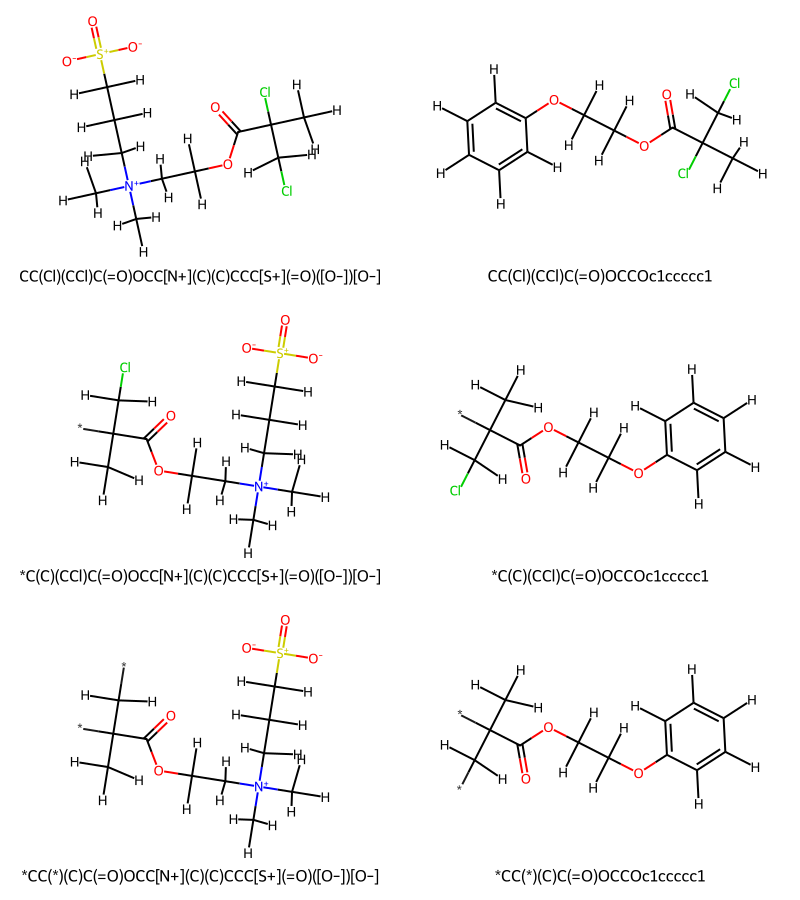

In [7]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor


reactor = PolymerizationReactor(rxn)
fragments = reactor.propagate_pooled(
    monomers.values(),
    # rxn_depth_max=3,
    clear_dummy_labels=True, # this makes identifying fragment superstructure easier in the following step
)
MolsToGridImage(fragments.values(), molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=fragments.keys())

## Find parent monomers and assign names + spec-compliant SMARTS

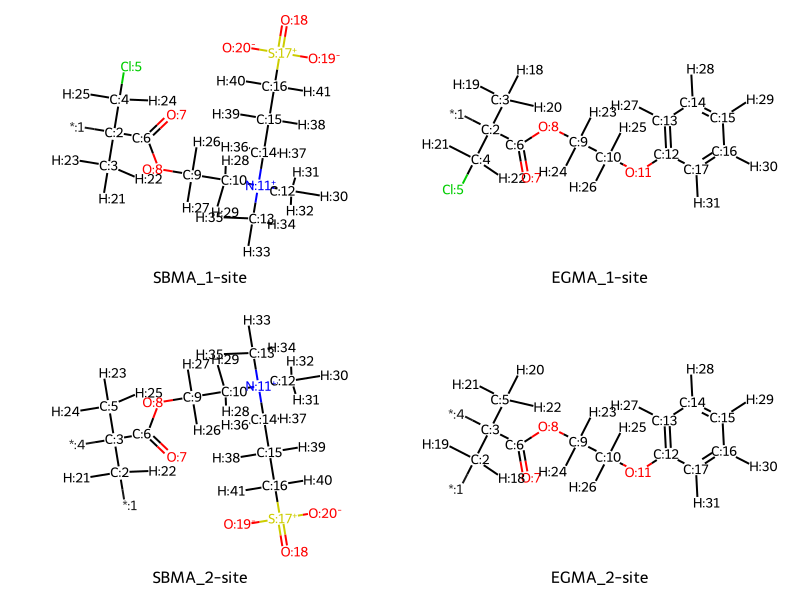

In [8]:
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_num_ports


named_fragments : dict[str, Smiles] = {}
for canon_smiles, fragment_mol in fragments.items():
    functionality = get_num_ports(fragment_mol)
    if functionality == 0:
        continue # skip fragments with no ports, as these are not useful for polymerization
    
    # find the parent monomer that contains this fragment
    query_mol = Chem.MolFromSmarts(canon_smiles) 
    parent_mol_name = '-'.join(name for name, monomer in monomers.items() if monomer.HasSubstructMatch(query_mol))
    named_fragments[f'{parent_mol_name}_{functionality}-site'] = canon_smiles
    
monogrp = MonomerGroup(named_fragments)
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

## Save fragments for reuse

SBMA_1-site


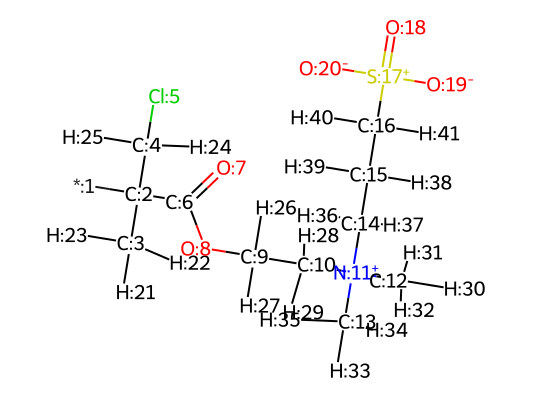

EGMA_1-site


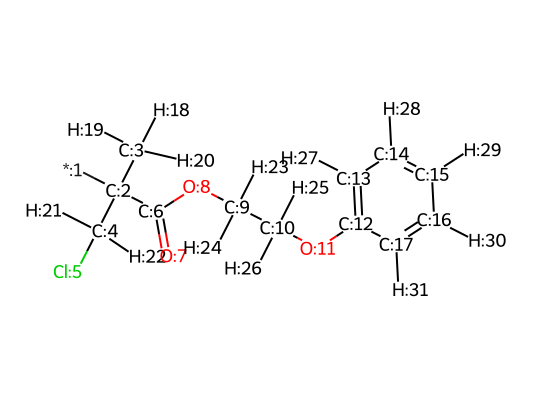

SBMA_2-site


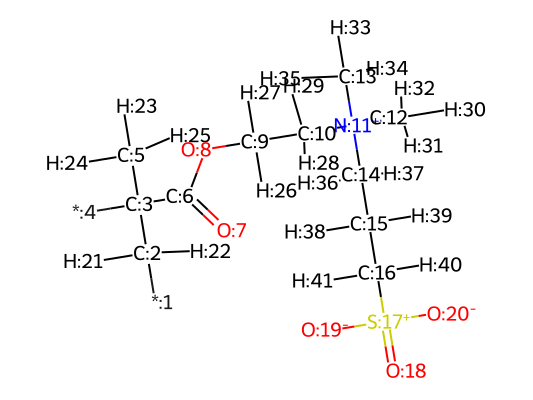

EGMA_2-site


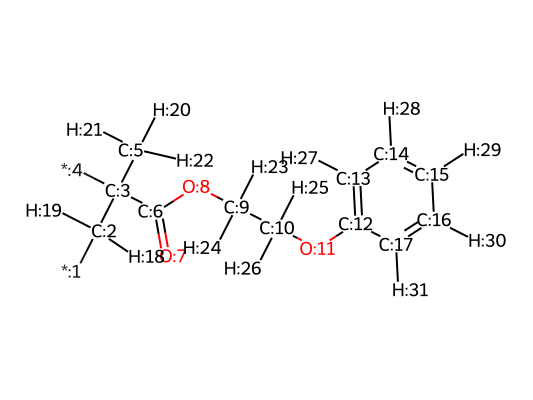

In [9]:
fragments_path = assemble_path(WORKING_DIR, project_name, postfix='fragments', extension='json')
monogrp.to_file(fragments_path)
for name, residue in monogrp.iter_rdmols():
    print(name)
    display(residue)

# Build a linear polymer from our newly-generated fragments

In [10]:
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb, mbmol_to_rdkit_pdb


n_monomers : int = 20 # number of MIDDLE monomers (not including end groups)

# not strictly necessary, but nice to show you can reload these fragments from prior builds
monogrp = MonomerGroup.from_file(fragments_path)
monogrp.term_orient = { # set explicit orientation for head and tail terminal groups
    'head' : 'SBMA_1-site',
    'tail' : 'EGMA_1-site',
}

# assemble polymer chain
chain = build_linear_polymer(
    monogrp,
    n_monomers=n_monomers,
    sequence='BA',
    # energy_minimize=True,
    energy_minimize=False,
)
chain.visualize()

polymer_name = f'{project_name}_{n_monomers}-mer'
pdb_path = assemble_path(WORKING_DIR, polymer_name, extension='pdb')
mbmol_to_openmm_pdb(
    pdb_path,
    chain,
    resname_map={ # rename to 3-letter residue names in PDB file
        'SBMA_1-site' : 'SB1',
        'SBMA_2-site' : 'SB2',
        'EGMA_1-site' : 'EG1',
        'EGMA_2-site' : 'EG2',
    },
)

[20:21:49] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.polymers.monomers.repr:Using user-defined terminal group orientation {'head': 'SBMA_1-site', 'tail': 'EGMA_1-site'}
INFO:polymerist.polymers.building.sequencing:Sequence kernel "BA" is already fully reduced; no changes made
INFO:polymerist.polymers.building.linear:Target chain length achievable with 9 whole 2-sequence repeat(s), namely with the sequence [SBMA_1-site] + 9*[BA] + [EGMA_1-site]
INFO:polymerist.polymers.building.linear:Registering middle monomer SBMA_2-site (block identifier "B")
[20:21:49] UFFTYPER: Unrecognized charge state for atom: 25
[20:21:49] UFFTYPER: Unrecognized charge state for atom: 25
INFO:polymerist.polymers.building.linear:Registering middle monomer EGMA_2-site (block identifier "A")
INFO:polymerist.polymers.building.linear:Registering terminal monomer SBMA_1-site (orientation "head")
[20:21:49] UFFTYPER: Unrecognized charge state for atom: 27
[20:21:49] UFFTYPER: Unreco

## Inject residue information into structure from fragments

In [11]:
from openff.toolkit import Topology
from polymerist.mdtools.openfftools.partition import partition
from polymerist.mdtools.openfftools.topology import topology_from_sdf, topology_to_sdf, get_largest_offmol


offtop = Topology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
was_partitioned = partition(offtop)
assert was_partitioned

sdf_path = assemble_path(WORKING_DIR, polymer_name, extension='sdf')
topology_to_sdf(sdf_path, offtop)

offmol = get_largest_offmol(offtop)
offmol.visualize(backend='nglview')

NGLWidget()

## Cache chemical info to SDF

In [12]:
from polymerist.mdtools.openfftools.partialcharge.molchargers import NAGLCharger, EspalomaCharger

charger = NAGLCharger()
# charger = EspalomaCharger()
charged_mol = charger.charge_molecule(offmol)
charged_top = charged_mol.to_topology()

sdf_path_charged = assemble_path(WORKING_DIR, polymer_name, postfix='charged', extension='sdf')
topology_to_sdf(sdf_path_charged, charged_top)

INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Assigning partial charges via the "NAGL" method
INFO:openff.nagl.nn._models:Could not find property in lookup table: 'Could not find property value for molecule with InChI InChI=1/C230H350Cl2N10O80S10/c1-211(191(243)303-121-111-233(21,22)101-71-151-323(263,264)265,163-219(9,200(252)314-142-132-294-182-83-53-42-54-84-182)165-213(3,193(245)305-123-113-235(25,26)103-73-153-325(269,270)271)167-221(11,202(254)316-144-134-296-184-87-57-44-58-88-184)169-215(5,195(247)307-125-115-237(29,30)105-75-155-327(275,276)277)171-223(13,204(256)318-146-136-298-186-91-61-46-62-92-186)173-217(7,197(249)309-127-117-239(33,34)107-77-157-329(281,282)283)175-226(16,206(258)320-148-138-300-188-95-65-48-66-96-188)177-228(18,179-231)208(260)311-129-119-241(37,38)109-79-159-331(287,288)289)161-218(8,199(251)313-141-131-293-181-81-51-41-52-82-181)162-212(2,192(244)304-122-112-234(23,24)102-72-152-324(266,267)268)164-220(10,201(253)315-143-133-295-183-85

## Solvate polymer chain in TIP3P water

In [13]:
from openmm.unit import Quantity, nanometer, gram, centimeter
from polymerist.mdtools.openfftools import boxvectors
from polymerist.mdtools.openfftools.solvation.packing import pack_topology_with_solvent
from polymerist.mdtools.openfftools.solvation.solvents import water_TIP3P


# set box parameters here
box_padding : Quantity = 1.0 * nanometer
target_density : Quantity = 1.0 * gram*centimeter**-3

# size box and box in water
box_vecs = boxvectors.pad_box_vectors_uniform(
    boxvectors.get_topology_bbox(charged_top),
    pad_amount=box_padding,
)
packtop = pack_topology_with_solvent(
    offtop=charged_top,
    solvent=water_TIP3P,
    box_vecs=box_vecs,
    density=target_density,
)
topology_to_sdf(
    assemble_path(WORKING_DIR, polymer_name, postfix='solvated', extension='sdf'),
    packtop,
)

INFO:polymerist.mdtools.openfftools.solvation.packing:Solvating 86.52235180711195 nm**3 Topology with 2893 water_TIP3P molecules to density of 1.0 g/(cm**3)
INFO:polymerist.mdtools.openfftools.solvation.packing:Packmol packing converged
INFO:polymerist.mdtools.openfftools.solvation.packing:Set solvated Topology box vectors to [[4.5161 0.0 0.0] [0.0 4.909199999999999 0.0] [0.0 0.0 3.902599999999999]] nanometer


# Run OpenMM Simulation

## Define thermodynamic, integrator, and checkpoint parameters for the simulation

In [ ]:
# define how you want to run your simulation
from openmm.unit import bar, kelvin, nanoseconds, picoseconds, femtoseconds
from polymerist.mdtools.openmmtools.parameters import (
    ThermoParameters,
    ThermostatParameters,
    BarostatParameters,
    IntegratorParameters,
    ReporterParameters,
    SimulationParameters,
)
from polymerist.mdtools.openmmtools.reporters import DEFAULT_STATE_DATA_PROPS


sim_params = SimulationParameters(
    thermo_params=ThermoParameters(
        thermostat_params=ThermostatParameters(
            temperature=300*kelvin,
            timescale=1*picoseconds**-1,
            thermostat='LangevinMiddle',
        ),
        barostat_params=BarostatParameters(
            pressure=1*bar,
            barostat='MC',
        )
    ),
    integ_params=IntegratorParameters(
        time_step=2*femtoseconds,
        total_time=1*picoseconds, # just a short simulation for illustration purposes
        num_samples=50,
    ),
    reporter_params=ReporterParameters(
        report_checkpoint=True,
        report_state=True,
        report_trajectory=True,
        report_state_data=True,
        traj_ext='dcd',
        state_data=DEFAULT_STATE_DATA_PROPS, # NOTE: you can tweak which of these you want to write out during a simulation
    )
)
sim_params.to_file(WORKING_DIR / 'example_sim.json')

## Loading OpenMM core objects

In [15]:
from openff.toolkit import ForceField
logging.getLogger('openff.interchange.smirnoff._nonbonded').setLevel(logging.CRITICAL) # suppress spammy "Preset charges..." logs otherwise printed for EVERY atom in an Interchange


ff = ForceField('openff-2.0.0.offxml')
inc = ff.create_interchange(packtop, charge_from_molecules=[charged_mol, water_TIP3P])
inc.box = box_vecs

omm_top = inc.to_openmm_topology(collate=True)
omm_sys = inc.to_openmm_system(combine_nonbonded_forces=False)
omm_pos = inc.get_positions(include_virtual_sites=True).to_openmm()

INFO:openff.toolkit.typing.engines.smirnoff.parameters:Attempting to up-convert vdW section from 0.3 to 0.4
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Successfully up-converted vdW section from 0.3 to 0.4. `method="cutoff"` is now split into `periodic_method="cutoff"` and `nonperiodic_method="no-cutoff"`.
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Attempting to up-convert Electrostatics section from 0.3 to 0.4
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Successfully up-converted Electrostatics section from 0.3 to 0.4. `method="PME"` is now split into `periodic_potential="Ewald3D-ConductingBoundary"`, `nonperiodic_potential="Coulomb"`, and `exception_potential="Coulomb"`.


# Run OpenMM Simulation schedule

In [16]:
from polymerist.genutils.logutils.IOHandlers import MSFHandlerFlex, get_active_loggers
from polymerist.mdtools.openmmtools.execution import run_simulation_schedule


logpath = assemble_path(WORKING_DIR, 'simulation_status', extension='log')
with MSFHandlerFlex(filename=logpath, proc_name='atrp_sims') as logger:
    history = run_simulation_schedule(
        working_dir=WORKING_DIR,
        schedule={
            'equilibration' : sim_params,
        },
        init_top=omm_top,
        init_sys=omm_sys,
        init_pos=omm_pos,
        return_history=True
    )

INFO:polymerist.mdtools.openmmtools.execution:Initializing simulation 1/1 ("equilibration")
INFO:polymerist.mdtools.openmmtools.thermo:Created MonteCarloBarostat Force for NPT (Isothermal-isobaric) ensemble
INFO:polymerist.mdtools.openmmtools.preparation:Registering new Force "MonteCarloBarostat" to System to enforce chosen ensemble (isothermal-isobaric)
INFO:polymerist.mdtools.openmmtools.thermo:Created LangevinMiddleIntegrator for NPT (Isothermal-isobaric) ensemble
INFO:polymerist.mdtools.openmmtools.preparation:Setting positions in Context
INFO:polymerist.mdtools.openmmtools.reporters:Prepared DCDReporter which reports to scratch_MD/ATRP_demo/equilibration/equilibration_trajectory.dcd
INFO:polymerist.mdtools.openmmtools.reporters:Prepared CheckpointReporter which reports to scratch_MD/ATRP_demo/equilibration/equilibration_checkpoint.chk
INFO:polymerist.mdtools.openmmtools.reporters:Prepared StateReporter which reports to scratch_MD/ATRP_demo/equilibration/equilibration_state.xml
INF